In [614]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../crispr_shrinkage/crispr_shrinkage/framework/')
import CrisprShrinkage as crispr_shrinkage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [615]:
from scipy.stats import binom
from scipy.stats import uniform
from scipy.stats import expon
import numpy as np 

null_proportion = 0.3
positive_proportion = 0.5
target_null_proportion = 0.3
target_positive_population = 0.7

num_ctrl_guides = 200
num_pos_guides = 50

reps = 3
max_dup_factor = 30
max_guide_molecule_factor = 20


get_positive_proportion = lambda pos_prop: ((1-pos_prop)*target_null_proportion) + (pos_prop)*target_positive_population

pop1_dup_factor_list = np.asarray([np.round(uniform.rvs(1, max_dup_factor)) for _ in range(reps)])
pop2_dup_factor_list = np.asarray([np.round(uniform.rvs(1, max_dup_factor)) for _ in range(reps)])

#expon.rvs(loc=1, scale=1000, size=num_guides)
#uniform.rvs(2, 200, size=num_guides)
def get_counts(num_guides, proportion):
    pop1_list_reps = []
    pop2_list_reps = []

    for rep_i in range(reps):
        n_list = np.round(uniform.rvs(2, max_guide_molecule_factor, size=num_guides)).astype(int)
        pop1_list = binom.rvs(n_list, proportion, size=num_guides) 
        pop2_list = n_list - pop1_list

        pop1_list_reps.append(pop1_list * pop1_dup_factor_list[rep_i])
        pop2_list_reps.append(pop2_list * pop2_dup_factor_list[rep_i])
    
    return np.asarray(pop1_list_reps), np.asarray(pop2_list_reps)


In [616]:
!pip list

Package                  Version     Editable project location
------------------------ ----------- -------------------------------------------------------------------------------------------------------------
anyio                    3.6.2
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
arrow                    1.2.3
asttokens                2.2.1
attrs                    22.2.0
backcall                 0.2.0
beautifulsoup4           4.11.2
bleach                   6.0.0
cffi                     1.15.1
colorama                 0.4.6
comm                     0.1.2
contourpy                1.0.7
crispr-shrinkage         0.1.0       C:\Users\bbece\Documents\Git-Projects\Git-Research-Software-Projects\crispr\crispr-shrinkage\crispr_shrinkage
cycler                   0.11.0
debugpy                  1.6.6
decorator                5.1.1
defusedxml               0.7.1
executing                1.2.0
fastjsonschema           2.16.2
fonttools                4.38.0
fqdn           

In [617]:

get_kernel_values = lambda position, b,xrange : np.asarray([crispr_shrinkage.StatisticalHelperMethods.gaussian_kernel(i, position, b) for i in range(position-xrange, position+xrange+1)])

normalize_kernel_values = lambda kernel_values: (kernel_values-kernel_values.min())/(kernel_values.max() - kernel_values.min())

kernel_values_50 = normalize_kernel_values(get_kernel_values(50, 5, 5))
kernel_values_100 = normalize_kernel_values(get_kernel_values(100, 3, 3))

kernel_values_150 = normalize_kernel_values(get_kernel_values(150, 10, 10))
kernel_values_200 = normalize_kernel_values(get_kernel_values(200, 15, 15))

In [618]:
tiling_length = 300


positive_regions = [(50,5,kernel_values_50), (100,3,kernel_values_100), (150,10,kernel_values_150), (200,15,kernel_values_200)]
observation_guides = []
for position in range(tiling_length):
    guide_proportion = target_null_proportion
    for positive_region in positive_regions:
        positive_region_range = np.asarray(range(positive_region[0]-positive_region[1], positive_region[0]+positive_region[1]+1))
        if position in positive_region_range:
            guide_positive_proportion = positive_region[2][np.where(positive_region_range==position)[0][0]]
            guide_proportion = get_positive_proportion(guide_positive_proportion)
    counts = get_counts(1, guide_proportion)

    pop1_raw_count_reps = counts[0].transpose()[0]
    pop2_raw_count_reps = counts[1].transpose()[0]
    guide = crispr_shrinkage.Guide(identifier="observation_{}".format(position), position=position, pop1_raw_count_reps= pop1_raw_count_reps, pop2_raw_count_reps=pop2_raw_count_reps)

    observation_guides.append(guide)

In [619]:
#tiling_length = 300

#positive_regions = [100, 200, 300]
#observation_guides = []
#for position in range(tiling_length):
#    counts = get_counts(1, target_null_proportion)#

#    pop1_raw_count_reps = counts[0].transpose()[0]
#    pop2_raw_count_reps = counts[1].transpose()[0]
#    guide = crispr_shrinkage.Guide(identifier="observation_{}".format(position), position=position, pop1_raw_count_reps= pop1_raw_count_reps, pop2_raw_count_reps=pop2_raw_count_reps)

#    observation_guides.append(guide)

#observation_guides = np.asarray(observation_guides)

In [620]:
observation_guides[0].pop2_raw_count_reps/pop2_dup_factor_list

array([4., 5., 8.])

In [621]:
negative_guides = []
for i in range(num_ctrl_guides):
    counts = get_counts(1, null_proportion)
    pop1_raw_count_reps = counts[0].transpose()[0]
    pop2_raw_count_reps = counts[1].transpose()[0]
    guide = crispr_shrinkage.Guide(identifier="negative_{}".format(i), position=None, pop1_raw_count_reps= pop1_raw_count_reps, pop2_raw_count_reps=pop2_raw_count_reps)

    negative_guides.append(guide)

negative_guides = np.asarray(negative_guides)

In [622]:
positive_guides = []
for i in range(num_pos_guides):
    counts = get_counts(1, positive_proportion)
    pop1_raw_count_reps = counts[0].transpose()[0] + 1
    pop2_raw_count_reps = counts[1].transpose()[0] + 1
    guide = crispr_shrinkage.Guide(identifier="positive_{}".format(i), position=None, pop1_raw_count_reps= pop1_raw_count_reps, pop2_raw_count_reps=pop2_raw_count_reps)

    positive_guides.append(guide)

positive_guides = np.asarray(positive_guides)

In [623]:
positive_proportion

0.5

Optimizing neighborhood imputation weights
X: [0.01857373 4.4866596 ], f: 36.230627573280195
X: [0.01114225 2.55993359], f: 25.7378723618254
X: [0.01114225 2.55993359], f: 20.61369962736602
X: [3.29463912e-04 2.10847002e+00], f: 8.197862127949895
X: [3.29463912e-04 2.10847002e+00], f: 7.577649665040911
X: [3.29463912e-04 2.10847002e+00], f: 6.397425946278764
X: [3.29463912e-04 1.28058187e+00], f: 3.8515469643690516
X: [3.29463912e-04 1.28058187e+00], f: 5.798699789734633
X: [3.29463912e-04 1.28058187e+00], f: 3.059400057327609
X: [0.00078224 0.53220096], f: 1.7122321444933464
X: [0.00078224 0.53220096], f: 2.015961805661449
X: [0.00078224 0.53220096], f: 2.8523564546605704
X: [0.00078224 0.53220096], f: 2.5803690844411227
X: [0.00078224 0.53220096], f: 1.6157398191824692
X: [0.00078224 0.53220096], f: 1.8445745332654155
X: [0.00078224 0.53220096], f: 1.599536825367527
X: [0.00160385 0.39934106], f: 2.3764973223590493
X: [0.00210261 0.01150545], f: 2.994463248594896
X: [0.00210261 0.011

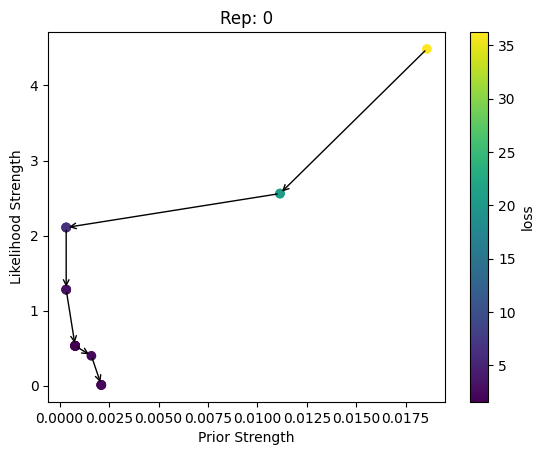

KL Negative Set Average: inf
KL Positive Set Average: inf
KL Observation Set Average: 2.572098139520252
KL Combined Set Average: 2.572098139520252
X: [0.17669067 0.98647743], f: 478.0600711961572
X: [0.03066353 0.3541991 ], f: 38.19929576247314
X: [0.00028627 0.22940011], f: 2.7397295461575695
X: [0.00028627 0.22940011], f: 2.3499341567633474
X: [0.00028627 0.22940011], f: 2.4257448866051634
X: [0.00028627 0.22940011], f: 2.342116954434869
X: [0.00028627 0.22940011], f: 2.0254881764190236
X: [0.00028627 0.22940011], f: 2.1406315999677474
X: [0.00028627 0.22940011], f: 1.9530594041781342
X: [0.00028627 0.22940011], f: 1.7766519747933125
X: [0.00028627 0.22940011], f: 1.9034830050208833
X: [3.25525750e-04 3.69757247e-01], f: 2.739711742414642
X: [3.25525750e-04 3.69757247e-01], f: 2.354662694729963
X: [3.25525750e-04 3.69757247e-01], f: 1.9519387148714775
X: [3.25525750e-04 3.69757247e-01], f: 2.535185824878313
X: [3.25525750e-04 3.69757247e-01], f: 2.064176011410099


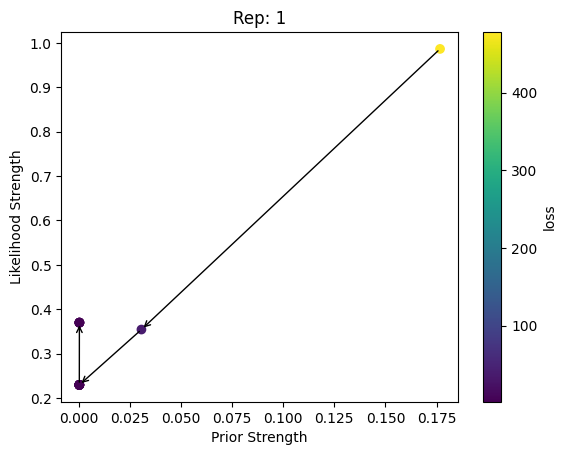

KL Negative Set Average: inf
KL Positive Set Average: inf
KL Observation Set Average: 2.336971372572445
KL Combined Set Average: 2.336971372572445
X: [0.08299594 1.84397347], f: 201.9273050724033
X: [0.05977249 2.23093025], f: 120.6374224974864
X: [0.02606288 0.75943808], f: 36.69057348952226
X: [3.13647426e-03 3.42844791e+00], f: 17.6686889617934
X: [3.13647426e-03 3.42844791e+00], f: 18.538751700720322
X: [3.13647426e-03 3.42844791e+00], f: 18.475586266232362
X: [3.13647426e-03 3.42844791e+00], f: 21.431972646224963
X: [0.00089759 0.83459824], f: 3.0484194312960815
X: [0.00089759 0.83459824], f: 3.886293557690946
X: [0.00089759 0.83459824], f: 4.095570505307956
X: [0.00089759 0.83459824], f: 3.740271675593352
X: [0.0007689  0.06099162], f: 2.4293973106939117
X: [0.00183704 0.28557021], f: 2.686666002124465
X: [0.00183704 0.28557021], f: 3.501270779443558
X: [0.00052651 0.23684024], f: 1.7317100293226269


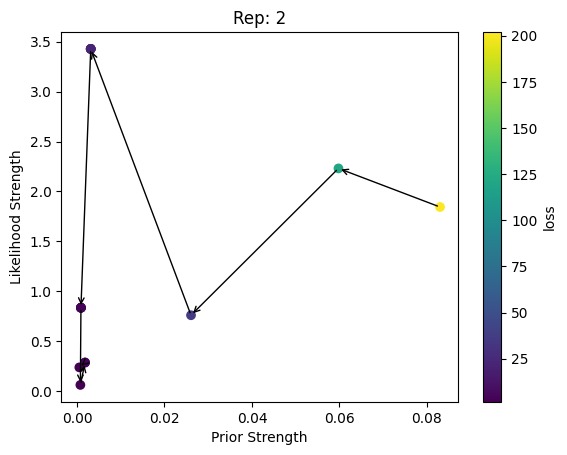

KL Negative Set Average: inf
KL Positive Set Average: inf
KL Observation Set Average: 2.1543554543271797
KL Combined Set Average: 2.1543554543271797
Selected neighborhood imputation weights: (array([0.00210261, 0.00032553, 0.00052651]), array([0.01150545, 0.36975725, 0.23684024]))
Optimizing singleton imputation weights
X: [0.0344987], f: 7.393899305278688
X: [0.02775663], f: 5.748350877290777
X: [0.02775663], f: 5.748350877290777
X: [0.01020388], f: 1.686287294921017
X: [0.00325817], f: 0.47178438768570763
X: [0.00325817], f: 0.47178438768570763
X: [0.00325817], f: 0.47178438768570763
X: [0.00317735], f: 0.46414946165973264
X: [0.00278654], f: 0.43281011580730316
X: [0.00278654], f: 0.43281011580730316
X: [0.00212847], f: 0.40811839368409164
X: [0.00212847], f: 0.40811839368409164
X: [0.00212847], f: 0.40811839368409164
X: [0.00210149], f: 0.408117856976819
X: [0.00211778], f: 0.40810654414005937


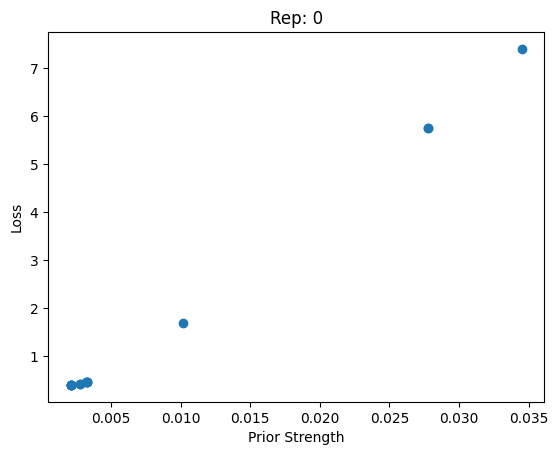

KL Negative Set Average: 0.35183535247453973
KL Positive Set Average: 0.6331883287138792
KL Observation Set Average: inf
KL Combined Set Average: 0.4081059477224076
X: [0.07145634], f: 17.85870001412224
X: [0.07145634], f: 17.85870001412224
X: [0.07145634], f: 17.85870001412224
X: [0.07145634], f: 17.85870001412224
X: [0.07145634], f: 17.85870001412224
X: [0.04584015], f: 10.976567211972824
X: [0.00420444], f: 0.6454328582886272
X: [0.00420444], f: 0.6454328582886272
X: [0.00274898], f: 0.4671919627674491
X: [0.00227598], f: 0.4381557409972487
X: [0.001753], f: 0.436956909806836
X: [0.00200206], f: 0.43242358530063973
X: [0.00200206], f: 0.43242358530063973
X: [0.00199467], f: 0.43241096305408044
X: [0.00198405], f: 0.43240725310039035


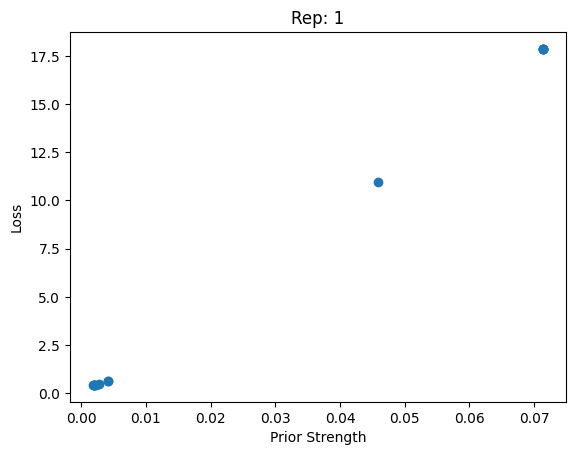

KL Negative Set Average: 0.35142902206051657
KL Positive Set Average: 0.7563167556123441
KL Observation Set Average: inf
KL Combined Set Average: 0.4324065687708821
X: [0.39120016], f: 113.01075706024452
X: [0.09159417], f: 25.02856103500053
X: [0.02288258], f: 5.380911092036529
X: [0.02288258], f: 5.380911092036529
X: [0.01361433], f: 2.899388803970608
X: [0.00672663], f: 1.2202580983014704
X: [0.00242776], f: 0.48371612572284667
X: [0.00242776], f: 0.48371612572284667
X: [0.00148496], f: 0.47641480113899154
X: [0.00224623], f: 0.47217564165924547
X: [0.00203306], f: 0.46359698922251824
X: [0.00192549], f: 0.4616758683706569
X: [0.00183913], f: 0.46148300306283696
X: [0.00184652], f: 0.46144913821183137
X: [0.00184652], f: 0.46144913821183137
X: [0.00186971], f: 0.4614053065399818


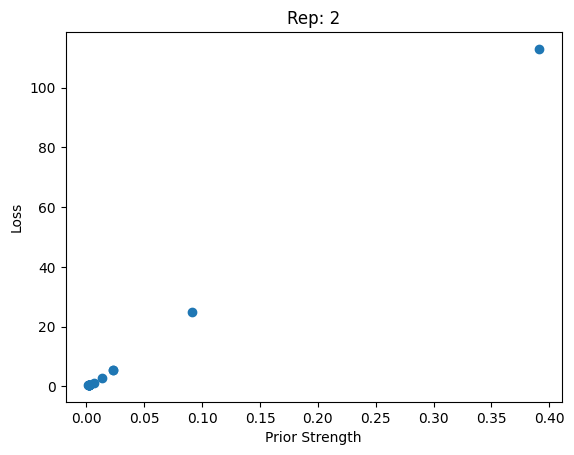

KL Negative Set Average: 0.40209924237275113
KL Positive Set Average: 0.6986293111226347
KL Observation Set Average: inf
KL Combined Set Average: 0.4614052561227278
Selected singleton imputation weights: [0.00211479 0.00198704 0.00186894]
Optimizing shrinkage prior weights
24.188362903525285
24.188362904915817
24.18835983738694
24.188359838777206
24.17227107573623
24.172271077142348
24.08899717398869
24.088997175478166
16.66908615113465
16.669086168187096
0.8624436286134518
0.8624435563939548
10.165892178169234
10.16589221789619
4.134826206997433
4.134826263661795
0.8621150053898852
0.8621150479034112
0.014945976363578417
0.014945983658587458
0.13583737984466104
0.13583735474005376
0.013233391640921077
0.013233384305877394
3.108760622261286e-05
3.108795021411481e-05
3.108760622261286e-05
X: [0.26923179], f: 3.108760622261286e-05
3.1082621743117045e-05
3.108296557918777e-05
2.103316074641981e-05
2.1033443742268787e-05
1.3328524950395604e-07
1.3326271197655615e-07
1.3328524950395604e-07


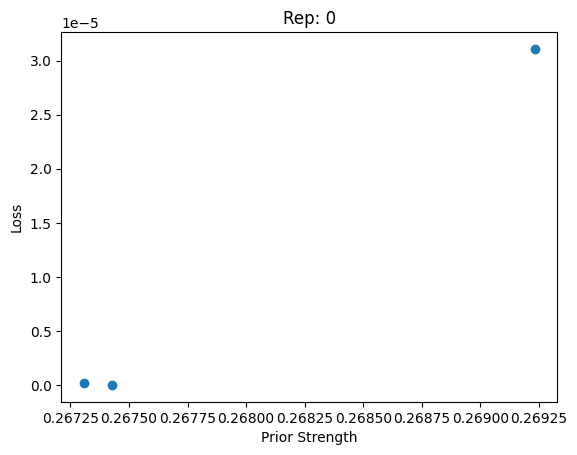

17.458320992765607
17.458320994401877
17.458317384322484
17.458317385958622
17.412809269068408
17.412809270748262
17.165929320759
17.165929322684725
2.8830637660536507
2.883063740175751
13.870287511784497
13.870287518394342
8.878485930808555
8.878485948223114
3.635202896877754
3.6352029248761353
0.6010905671741007
0.6010905873174099
0.008033549512820315
0.00803354639062892
0.14010287396828414
0.14010288521471015
0.022764334513358797
0.022764339389080845
0.0010809034811432028
0.0010809045836612796
0.0007725406119707401
0.0007725396621527381
7.2045993171343525e-06
7.204690155582227e-06
7.2045993171343525e-06
X: [0.62729656], f: 7.2045993171343525e-06
7.204368190905086e-06
7.204459051557421e-06
3.197442310920451e-12
3.064215547965432e-12
3.197442310920451e-12
X: [0.62571032], f: 3.197442310920451e-12
1.3012702027026535e-09
1.3024470391087561e-09
9.325873406851315e-13
8.881784197001252e-13
4.942712905631197e-11
4.9760195963699516e-11
9.325873406851315e-13
X: [0.6257108], f: 9.3258734068513

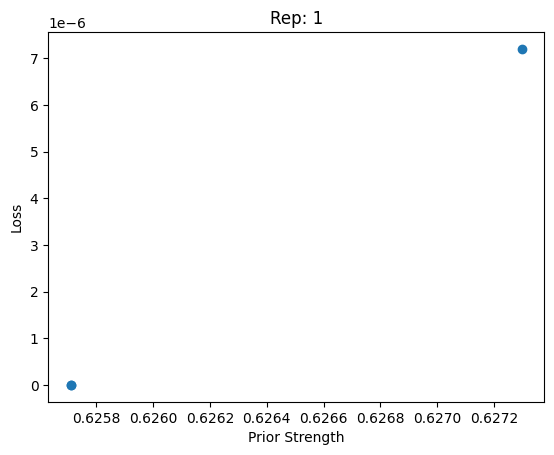

14.633987667535852
14.633987668425629
14.63398570508474
14.63398570597474
30.36201996442509
30.362019582411047
12.634440525155565
12.634440529398727
8.554005796263887
8.554005811089983
3.1434002995566424
3.1434003283551393
0.044588959673386164
0.04458896767260967
1.832595409518789
1.832595320558772
0.21534564627760933
0.21534562343519248
0.010892771935266943
0.010892767442860496
0.003414496299458669
0.00341449865730592
0.00046880586175301886
0.00046880495954138013
0.0003501573379693923
0.0003501581051557068
1.9277201390721643e-06
1.9276627627462517e-06
1.9277201390721643e-06
X: [1.14257907], f: 1.9277201390721643e-06
1.9275737006552163e-06
1.9275163243293036e-06
2.220446049250313e-14
2.220446049250313e-14
2.220446049250313e-14
X: [1.14325102], f: 2.220446049250313e-14


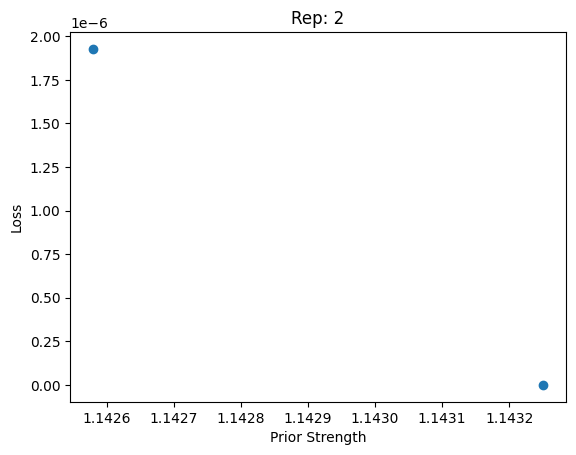

Selected shrinkage prior weights: [0.26742551 0.6257108  1.14325102]
NEGATIVE_CONTROLS
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.50426156]
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.50426156]
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.50426156]
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.50426156]
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.50426156]
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.50426156]
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.50426156]
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.50426156]
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.50426156]
Shrinkage Prior: a=[1.85678817 1.85192584 1.78109934], b=[3.90390769 3.7316703  3.504

In [624]:
# LEFTOFF - just modifed result to return each guide set separately. So should be able to plot by position and verify that the shrinkage and all works well. Very interested to see if the negatiev controls are over shrunk. and positive controls. since they dont have position.
results1 = crispr_shrinkage.perform_adjustment(
    negative_control_guides = negative_guides,
    positive_control_guides = positive_guides,
    observation_guides = observation_guides,
    num_replicates = 3,
    include_observational_guides_in_fit = False,
    include_positive_control_guides_in_fit = False,
    pop1_amplification_factors = pop1_dup_factor_list,
    pop2_amplification_factors = pop2_dup_factor_list,
    monte_carlo_trials = 1000,
    enable_spatial_prior =  True,
    spatial_bandwidth = 7,
    neighborhood_imputation_model_weights = None,#[[7.95575502e-06, 4.27615751e-04, 7.04972615e-04],[0.54760046, 0.238465  , 0.16078946]],
    singleton_imputation_model_weights = None, #[0.00128053, 0.00142116, 0.00132117],
    baseline_proportion = 0.5, # TODO: Perform validation between (0,1), also accept None value for perfrming no normalization (or have that be another argument)
    deviation_weights = np.asarray([10,10,10]),
    KL_score_weights = None,
    shrinkage_prior_strength = None, #np.asarray([4.48726865, 0.37900204, 5.44992066]),
    posterior_estimator = "mean",
    random_seed = 234
    )


In [625]:
results = results1

In [626]:
positive_positions1 = [guide.position for guide in results1.adjusted_positive_control_guides]
observational_position1 = [guide.position for guide in results1.adjusted_observation_guides]

In [627]:
positive_positions = [guide.position for guide in results.adjusted_positive_control_guides]
observational_position = [guide.position for guide in results.adjusted_observation_guides]

In [628]:
negative_lfc = [guide.LFC_estimate_combined for guide in results.adjusted_negative_control_guides]
positive_lfc = [guide.LFC_estimate_combined for guide in results.adjusted_positive_control_guides]
observational_lfc = [guide.LFC_estimate_combined for guide in results.adjusted_observation_guides]

In [629]:
negative_lfc1 = [guide.LFC_estimate_combined for guide in results1.adjusted_negative_control_guides]
positive_lfc1 = [guide.LFC_estimate_combined for guide in results1.adjusted_positive_control_guides]
observational_lfc1 = [guide.LFC_estimate_combined for guide in results1.adjusted_observation_guides]

negative_lfc2 = [guide.LFC_estimate_combined for guide in results2.adjusted_negative_control_guides]
positive_lfc2 = [guide.LFC_estimate_combined for guide in results2.adjusted_positive_control_guides]
observational_lfc2 = [guide.LFC_estimate_combined for guide in results2.adjusted_observation_guides]

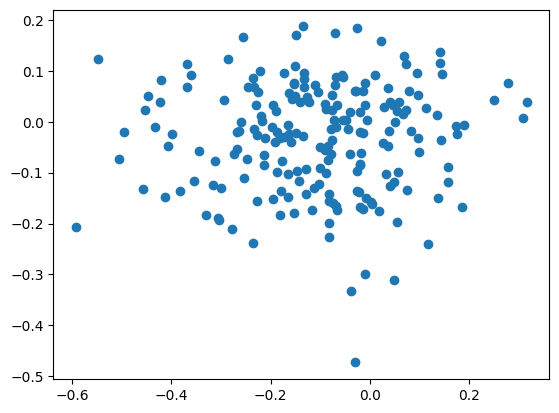

In [630]:
plt.scatter(negative_lfc, negative_lfc2)

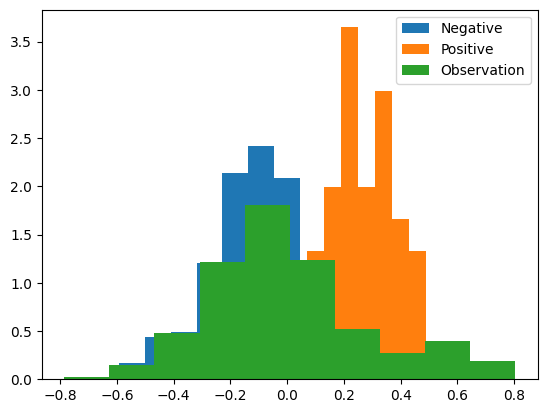

In [631]:
import matplotlib.pyplot as plt
plt.hist(negative_lfc, density=True, label="Negative")
plt.hist(positive_lfc, density=True, label="Positive")
plt.hist(observational_lfc, density=True, label="Observation")
plt.legend()

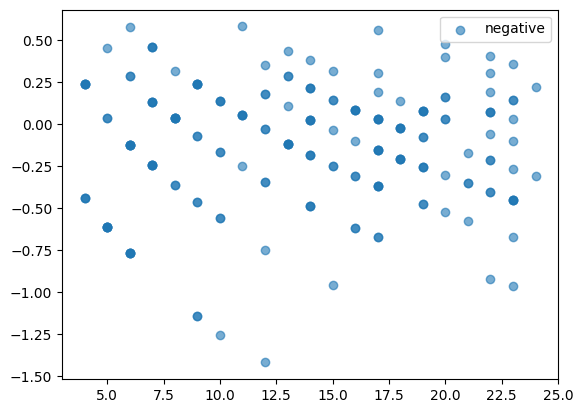

In [632]:
reps = range(3)
observational_lfc_rep = [[guide.LFC_estimate_per_replicate[rep_i] for guide in results.adjusted_observation_guides] for rep_i in reps]
observational_count_rep = [[guide.pop1_normalized_count_reps[rep_i] + guide.pop2_normalized_count_reps[rep_i] for guide in results.adjusted_observation_guides] for rep_i in reps]
positive_lfc_rep = [[guide.LFC_estimate_per_replicate[rep_i] for guide in results.adjusted_positive_control_guides]  for rep_i in reps]
positive_count_rep = [[guide.pop1_normalized_count_reps[rep_i] + guide.pop2_normalized_count_reps[rep_i] for guide in results.adjusted_positive_control_guides]  for rep_i in reps]

negative_lfc_rep = [[guide.LFC_estimate_per_replicate[rep_i] for guide in results.adjusted_negative_control_guides]  for rep_i in reps]

negative_count_rep = [[guide.pop1_normalized_count_reps[rep_i] + guide.pop1_normalized_count_reps[rep_i] for guide in results.adjusted_negative_control_guides] for rep_i in reps] # WRONG
negative_count_rep = [[guide.pop1_normalized_count_reps[rep_i] + guide.pop2_normalized_count_reps[rep_i] for guide in results.adjusted_negative_control_guides] for rep_i in reps] # RIGHT

#plt.scatter(observational_count_rep, observational_lfc_rep, alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_lfc_rep, alpha=0.6, label="positive")
plt.scatter(negative_count_rep[0], negative_lfc_rep[0], alpha=0.6, label="negative")
plt.legend()
plt.show()

In [633]:
pop1_negative_controls = np.asarray([guide.pop1_normalized_count_reps  for guide in results.adjusted_negative_control_guides]).sum(axis=0)

pop2_negative_controls = np.asarray([guide.pop2_normalized_count_reps  for guide in results.adjusted_negative_control_guides]).sum(axis=0)

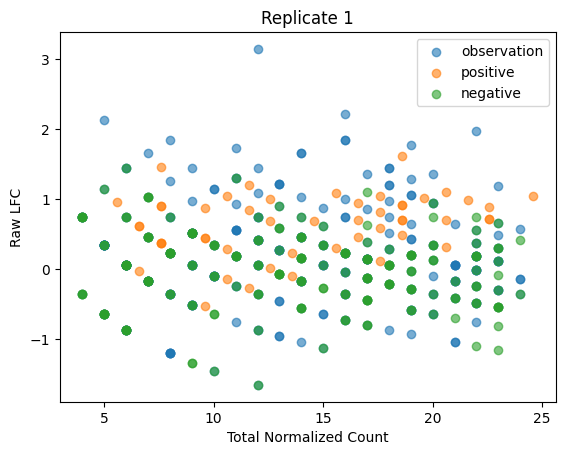

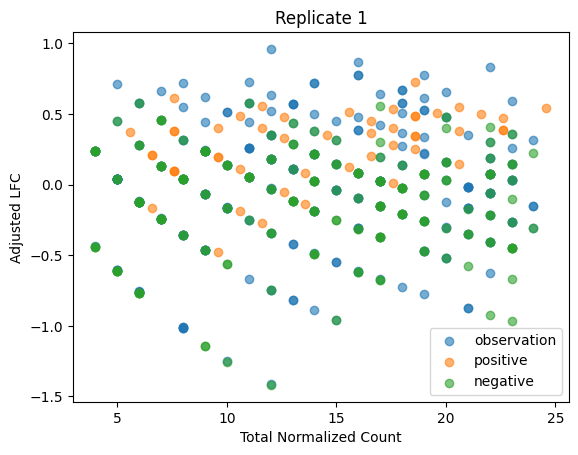

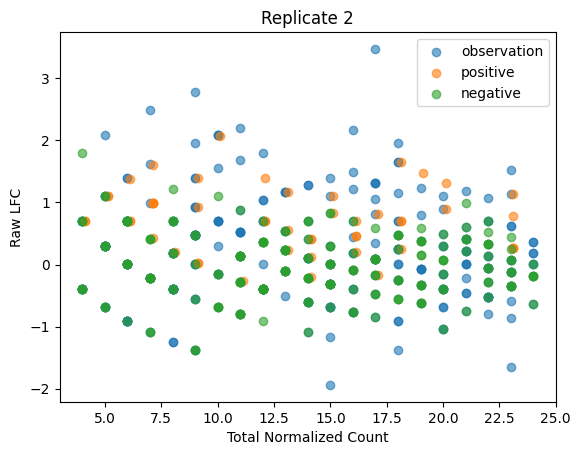

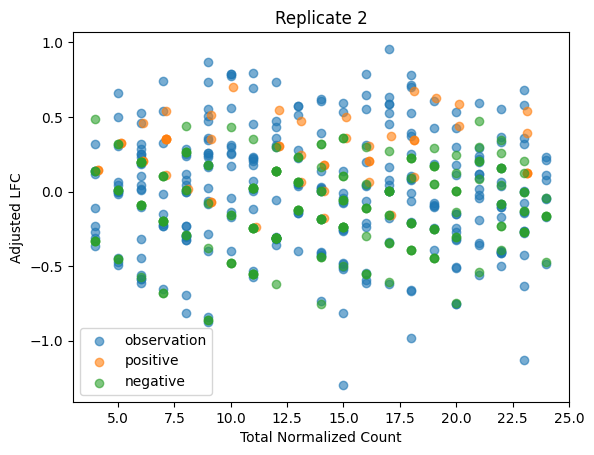

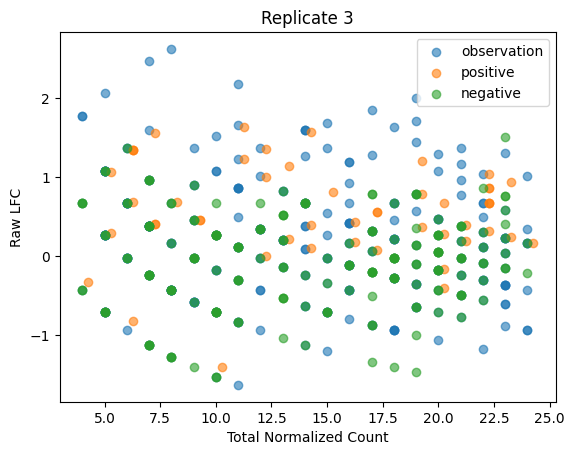

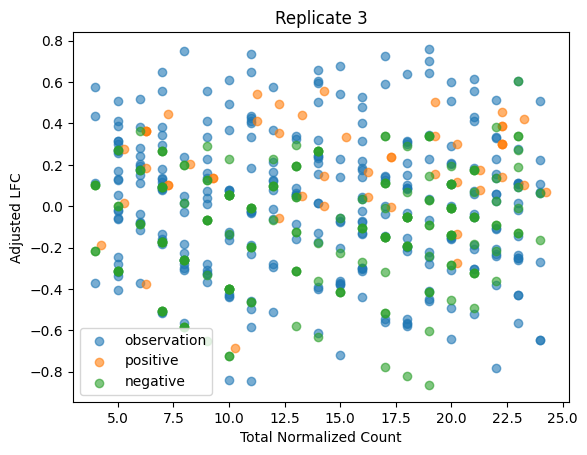

In [634]:
observational_raw_lfc_rep = [[np.log((guide.pop1_normalized_count_reps[rep_i] * pop2_negative_controls[rep_i])/(guide.pop2_normalized_count_reps[rep_i] * pop1_negative_controls[rep_i])) for guide in results.adjusted_observation_guides]  for rep_i in reps]

positive_raw_lfc_rep = [[np.log((guide.pop1_normalized_count_reps[rep_i] * pop2_negative_controls[rep_i])/(guide.pop2_normalized_count_reps[rep_i] * pop1_negative_controls[rep_i])) for guide in results.adjusted_positive_control_guides] for rep_i in reps]

negative_raw_lfc_rep = [[np.log((guide.pop1_normalized_count_reps[rep_i] * pop2_negative_controls[rep_i])/(guide.pop2_normalized_count_reps[rep_i] * pop1_negative_controls[rep_i])) for guide in results.adjusted_negative_control_guides]  for rep_i in reps]

for rep_i in range(3):
    plt.scatter(observational_count_rep[rep_i], observational_raw_lfc_rep[rep_i], alpha=0.6, label="observation")
    plt.scatter(positive_count_rep[rep_i], positive_raw_lfc_rep[rep_i], alpha=0.6, label="positive")
    plt.scatter(negative_count_rep[rep_i], negative_raw_lfc_rep[rep_i], alpha=0.6, label="negative")
    plt.xlabel("Total Normalized Count")
    plt.ylabel("Raw LFC")
    plt.title("Replicate {}".format(rep_i+1))
    plt.legend()
    plt.show()

    plt.scatter(observational_count_rep[rep_i], observational_lfc_rep[rep_i], alpha=0.6, label="observation")
    plt.scatter(positive_count_rep[rep_i], positive_lfc_rep[rep_i], alpha=0.6, label="positive")
    plt.scatter(negative_count_rep[rep_i], negative_lfc_rep[rep_i], alpha=0.6, label="negative")
    plt.xlabel("Total Normalized Count")
    plt.ylabel("Adjusted LFC")
    plt.title("Replicate {}".format(rep_i+1))
    plt.legend()
    plt.show()

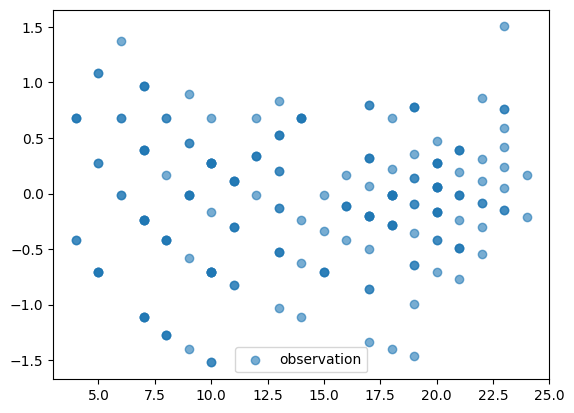

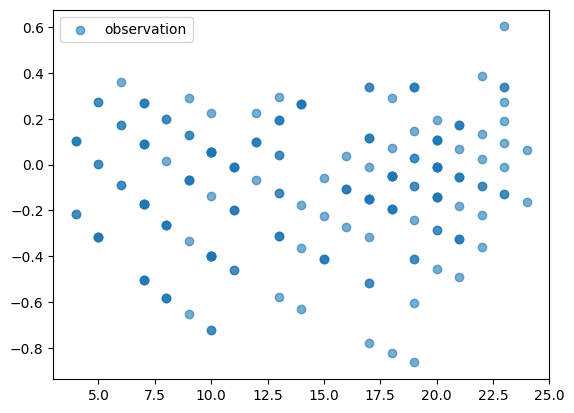

In [635]:
rep_i = 2
plt.scatter(negative_count_rep[rep_i], negative_raw_lfc_rep[rep_i], alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_raw_lfc_rep, alpha=0.6, label="positive")
#plt.scatter(negative_count_rep, negative_raw_lfc_rep, alpha=0.6, label="negative")
plt.legend()
plt.show()

plt.scatter(negative_count_rep[rep_i], negative_lfc_rep[rep_i], alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_raw_lfc_rep, alpha=0.6, label="positive")
#plt.scatter(negative_count_rep, negative_raw_lfc_rep, alpha=0.6, label="negative")
plt.legend()
plt.show()

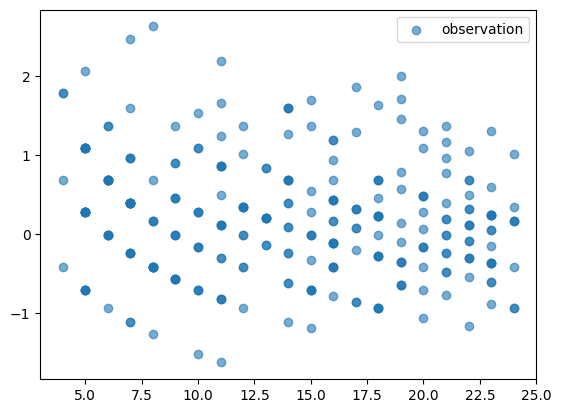

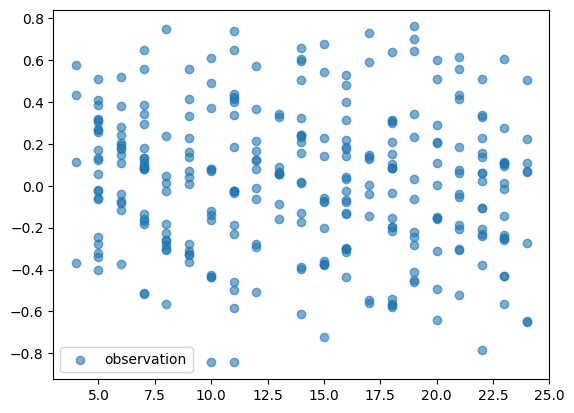

In [636]:
rep_i=2
plt.scatter(observational_count_rep[rep_i], observational_raw_lfc_rep[rep_i], alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_raw_lfc_rep, alpha=0.6, label="positive")
#plt.scatter(negative_count_rep, negative_raw_lfc_rep, alpha=0.6, label="negative")
plt.legend()
plt.show()

plt.scatter(observational_count_rep[rep_i], observational_lfc_rep[rep_i], alpha=0.6, label="observation")
#plt.scatter(positive_count_rep, positive_raw_lfc_rep, alpha=0.6, label="positive")
#plt.scatter(negative_count_rep, negative_raw_lfc_rep, alpha=0.6, label="negative")
plt.legend()
plt.show()

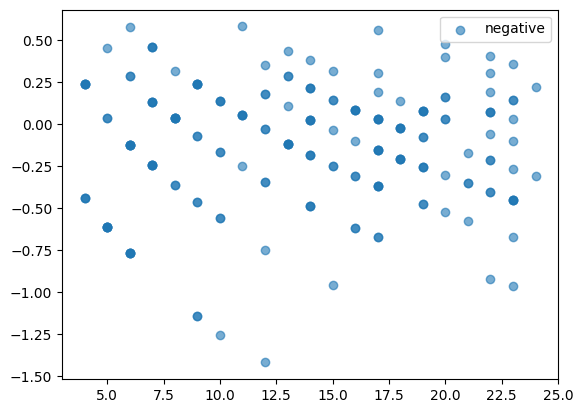

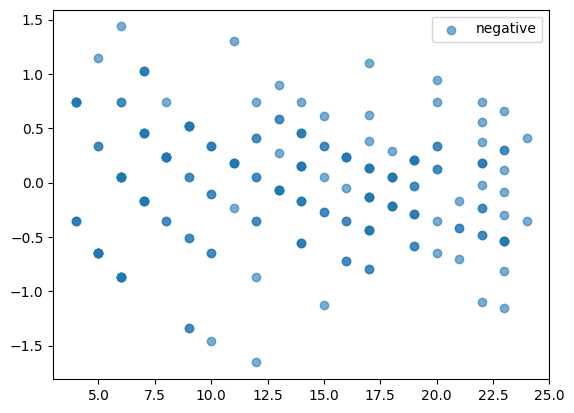

In [637]:
plt.scatter(negative_count_rep[0], negative_lfc_rep[0], alpha=0.6, label="negative")
plt.legend()
plt.show()

plt.scatter(negative_count_rep[0], negative_raw_lfc_rep[0], alpha=0.6, label="negative")
plt.legend()
plt.show()

In [638]:
negative_count_rep[rep_i]

[5.0,
 19.0,
 12.0,
 23.0,
 5.0,
 11.0,
 14.0,
 14.0,
 20.0,
 18.0,
 19.0,
 20.0,
 17.0,
 9.0,
 6.0,
 16.0,
 5.0,
 22.0,
 7.0,
 22.0,
 8.0,
 10.0,
 6.0,
 17.0,
 13.0,
 21.0,
 11.0,
 23.0,
 13.0,
 7.0,
 19.0,
 10.0,
 10.0,
 23.0,
 4.0,
 17.0,
 8.0,
 8.0,
 5.0,
 22.0,
 17.0,
 17.0,
 22.0,
 18.0,
 20.0,
 20.0,
 10.0,
 4.0,
 11.0,
 20.0,
 4.0,
 20.0,
 4.0,
 10.0,
 7.0,
 19.0,
 5.0,
 9.0,
 20.0,
 19.0,
 6.0,
 20.0,
 18.0,
 9.0,
 10.0,
 18.0,
 17.0,
 13.0,
 20.0,
 14.0,
 9.0,
 19.0,
 7.0,
 19.0,
 6.0,
 9.0,
 7.0,
 17.0,
 5.0,
 14.0,
 18.0,
 18.0,
 18.0,
 10.0,
 10.0,
 11.0,
 21.0,
 17.0,
 18.0,
 16.0,
 8.0,
 21.0,
 15.0,
 17.0,
 17.0,
 19.0,
 7.0,
 7.0,
 11.0,
 23.0,
 9.0,
 20.0,
 7.0,
 19.0,
 10.0,
 21.0,
 17.0,
 7.0,
 11.0,
 7.0,
 9.0,
 20.0,
 12.0,
 20.0,
 8.0,
 20.0,
 20.0,
 14.0,
 23.0,
 23.0,
 16.0,
 13.0,
 22.0,
 23.0,
 14.0,
 18.0,
 13.0,
 17.0,
 13.0,
 11.0,
 8.0,
 7.0,
 21.0,
 14.0,
 6.0,
 8.0,
 10.0,
 15.0,
 19.0,
 7.0,
 15.0,
 12.0,
 19.0,
 20.0,
 16.0,
 10.0,
 8.0,
 24.0,
 8.0,


In [639]:
negative_lfc_rep[rep_i]

[-0.3151052365112664,
 -0.6051461510333783,
 0.09813864683530682,
 -0.009588370740784672,
 0.2727994947162789,
 -0.009683858401545242,
 0.2649851481104059,
 -0.6306523205166469,
 0.1948980544925222,
 -0.05068107921923663,
 0.031021297521597258,
 0.10796267219028385,
 0.11413811029455911,
 -0.33222810120000174,
 -0.08769125084778172,
 0.03600461649583124,
 0.2727994947162789,
 -0.09148534528591004,
 0.2676505351735932,
 0.3851313994537548,
 -0.5819231404213351,
 0.2263909112324948,
 -0.08769125084778172,
 0.11413811029455911,
 0.0425580014276143,
 0.06960016328946321,
 -0.009683858401545242,
 0.27302710654862145,
 -0.12295637180101829,
 -0.5056649321514995,
 -0.09230493021438849,
 0.053079088814313176,
 -0.39892369616877793,
 0.09417640098451961,
 0.10297442911374162,
 -0.14969147366129515,
 -0.26137951782460783,
 -0.26137951782460783,
 -0.3151052365112664,
 -0.21811622877446285,
 -0.5160299386261309,
 -0.14969147366129515,
 0.026094988902022147,
 0.07064380059901434,
 -0.00895215659406

In [640]:
rep_i = 1
print(crispr_shrinkage.StatisticalHelperMethods.calculate_breusch_pagan(negative_count_rep[rep_i], negative_lfc_rep[rep_i]))
print(crispr_shrinkage.StatisticalHelperMethods.calculate_breusch_pagan(negative_count_rep[rep_i], negative_raw_lfc_rep[rep_i]))

3.8763610700374596
15.318691368431114


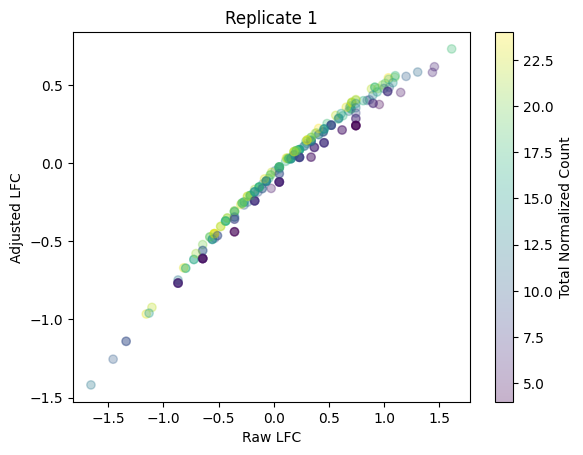

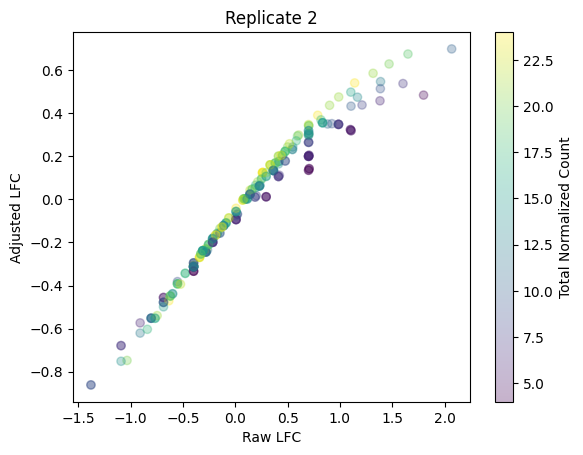

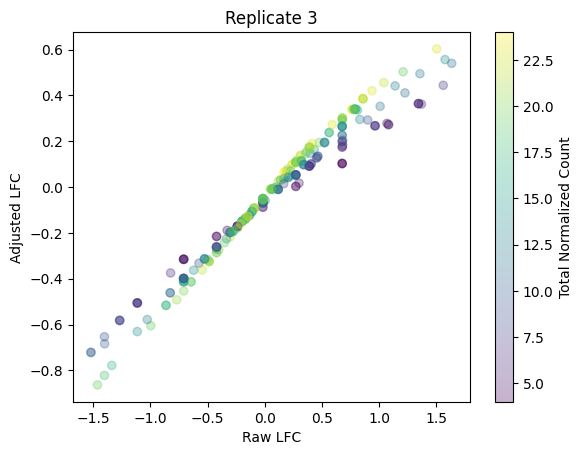

In [641]:
#plt.scatter(observational_raw_lfc_rep, observational_lfc_rep, c=observational_count_rep, marker=",", alpha=0.3)
for rep_i in range(3):
    plt.scatter(positive_raw_lfc_rep[rep_i], positive_lfc_rep[rep_i], c=positive_count_rep[rep_i], alpha=0.3, marker="o")
    plt.scatter(negative_raw_lfc_rep[rep_i], negative_lfc_rep[rep_i], c=negative_count_rep[rep_i], alpha=0.3, marker="o")
    plt.colorbar(label="Total Normalized Count")
    plt.xlabel("Raw LFC")
    plt.ylabel("Adjusted LFC")
    plt.title("Replicate {}".format(rep_i + 1))
    plt.show()

In [642]:
# LEFTOFF - Simulated a tiled region and troubleshoot. May need to adjust the loss function to prioritize differential guides.

In [643]:
# LEFTOFF: It seems that the shrinkage optimization is not working appropriately. I wonder if it is due to the position-less guide counts. Try and increase the position-containing positive control guides to see how the respond to shrinkage. Also compare the LFC before and after and validate where shrinkage is. Would also be nice to create another simulation example to test neighborhood. Also try and plot intermediate plots in the package (i.e. visualizing and logging optimization performance.)

In [644]:
positive_regions

[(50,
  5,
  array([0.        , 0.3040094 , 0.58134022, 0.80460065, 0.94967505,
         1.        , 0.94967505, 0.80460065, 0.58134022, 0.3040094 ,
         0.        ])),
 (100,
  3,
  array([0.        , 0.49357529, 0.86265631, 1.        , 0.86265631,
         0.49357529, 0.        ])),
 (150,
  10,
  array([0.        , 0.15362354, 0.3040094 , 0.44774487, 0.58134022,
         0.70136657, 0.80460065, 0.88816786, 0.94967505, 0.98732425,
         1.        , 0.98732425, 0.94967505, 0.88816786, 0.80460065,
         0.70136657, 0.58134022, 0.44774487, 0.3040094 , 0.15362354,
         0.        ])),
 (200,
  15,
  array([0.        , 0.10261159, 0.20427741, 0.3040094 , 0.40078728,
         0.49357529, 0.58134022, 0.66307025, 0.73779421, 0.80460065,
         0.86265631, 0.91122337, 0.94967505, 0.97750905, 0.99435851,
         1.        , 0.99435851, 0.97750905, 0.94967505, 0.91122337,
         0.86265631, 0.80460065, 0.73779421, 0.66307025, 0.58134022,
         0.49357529, 0.40078728, 0.3040

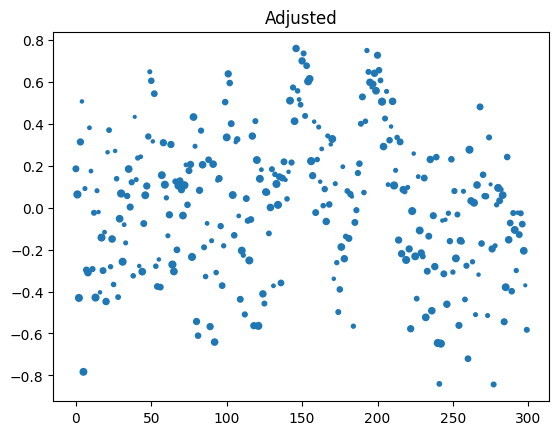

Text(0.5, 1.0, 'Raw')

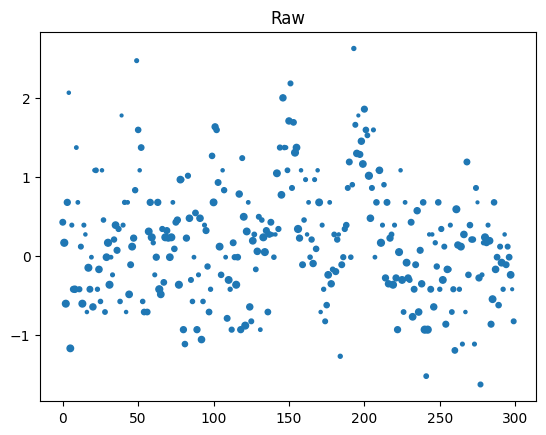

In [645]:
rep_i = 2
plt.scatter(observational_position, observational_lfc_rep[rep_i], s=observational_count_rep[rep_i])
plt.title("Adjusted")
plt.show()
plt.scatter(observational_position, observational_raw_lfc_rep[rep_i], s=observational_count_rep[rep_i])
plt.title("Raw")

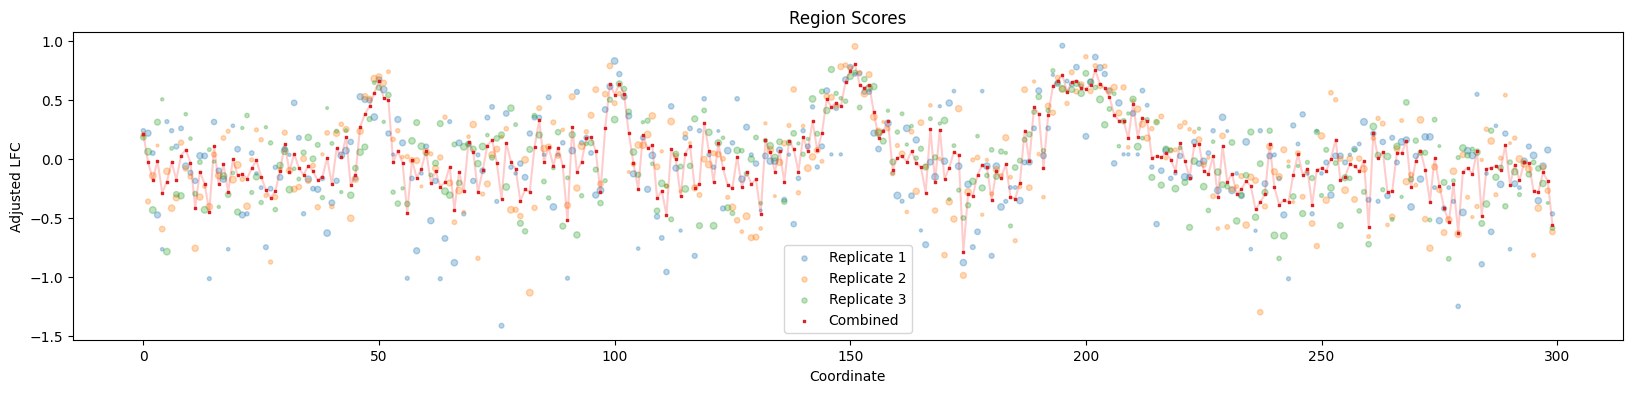

In [679]:
fig = plt.figure(figsize=(20, 4))

# Adds subplot on position 1
ax = fig.add_subplot(111)

ax.scatter(observational_position, observational_lfc_rep[0], s=observational_count_rep[0], alpha=0.3, label="Replicate 1")
ax.scatter(observational_position, observational_lfc_rep[1], s=observational_count_rep[1], alpha=0.3, label="Replicate 2")
ax.scatter(observational_position, observational_lfc_rep[2], s=observational_count_rep[2], alpha=0.3, label="Replicate 3")
ax.scatter(observational_position, observational_lfc, marker="s", s=2, label="Combined")
ax.plot(observational_position, observational_lfc,color="red", alpha=0.2)
ax.set_title("Region Scores")
ax.set_xlabel("Coordinate")
ax.set_ylabel("Adjusted LFC")
ax.legend()

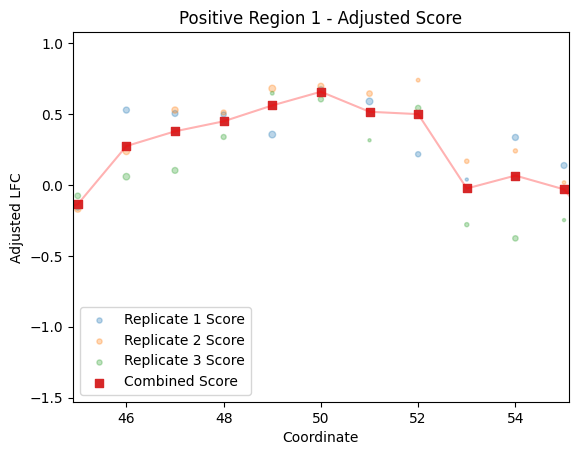

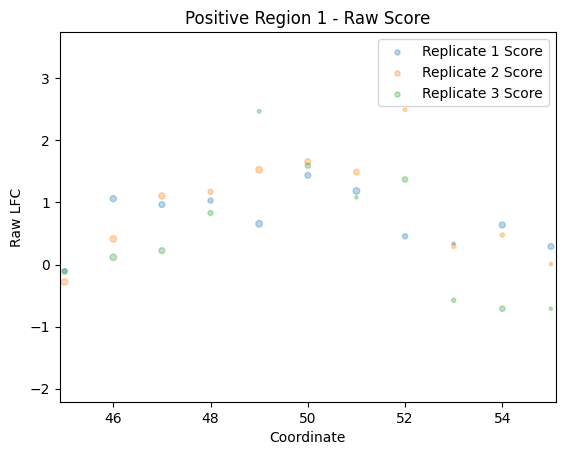

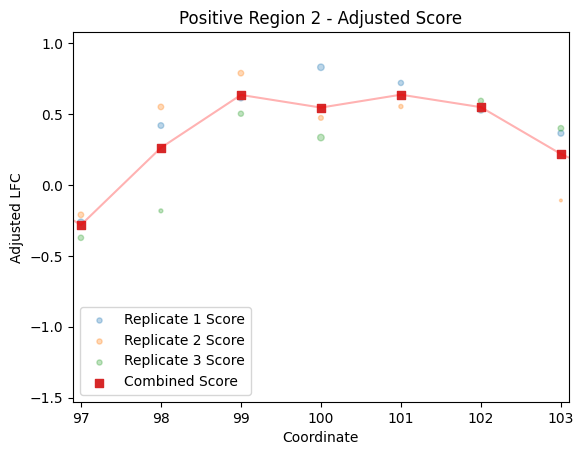

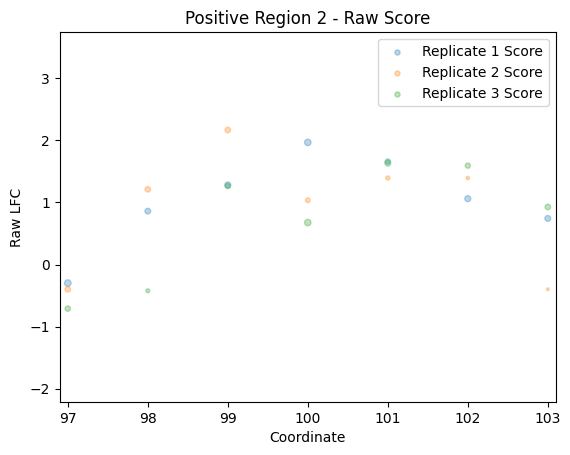

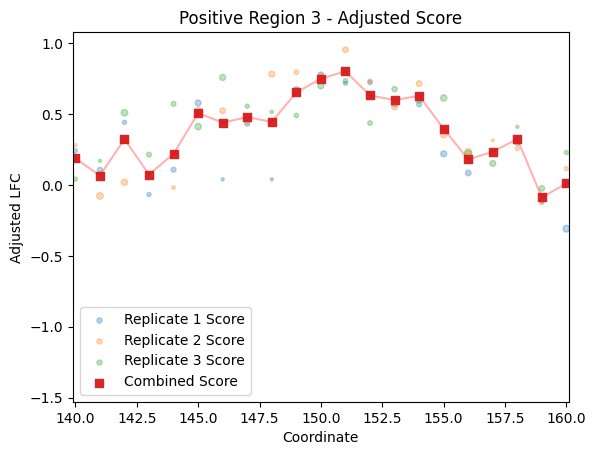

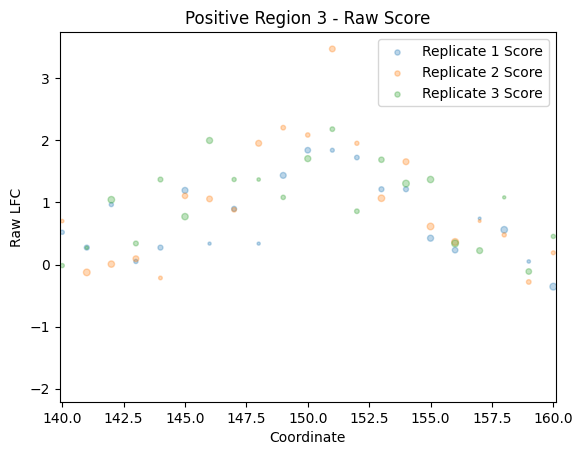

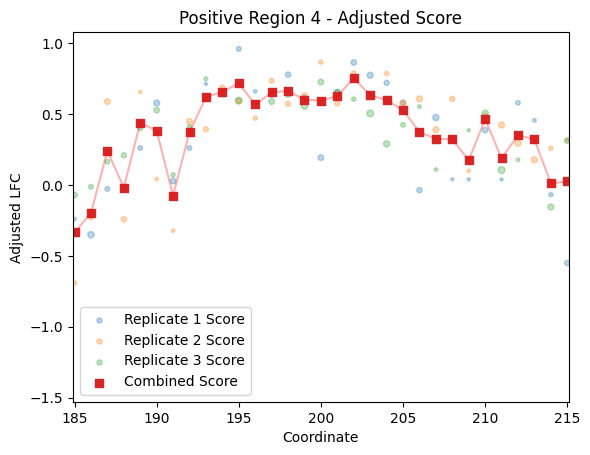

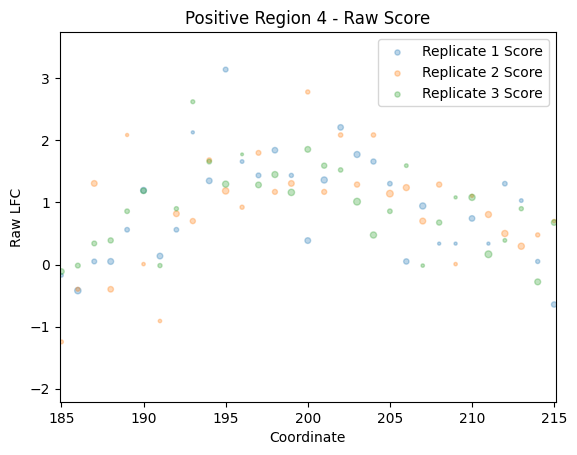

In [672]:
for reg_i, positive_region in enumerate(positive_regions):
    
    for rep_i in range(3):
        plt.scatter(observational_position, observational_lfc_rep[rep_i], s=observational_count_rep[rep_i], alpha=0.3, label="Replicate {} Score".format(rep_i + 1))

    plt.scatter(observational_position, observational_lfc, marker="s", label="Combined Score")
    plt.plot(observational_position, observational_lfc, color="red", alpha=0.3)
    plt.xlim(positive_region[0]-positive_region[1] - 0.1, positive_region[0]+positive_region[1] + 0.1)
    plt.title("Positive Region {} - Adjusted Score".format(reg_i+1))
    plt.xlabel("Coordinate")
    plt.ylabel("Adjusted LFC")
    plt.legend()
    plt.show()
    for rep_i in range(3):
        plt.scatter(observational_position, observational_raw_lfc_rep[rep_i], s=observational_count_rep[rep_i], alpha=0.3, label="Replicate {} Score".format(rep_i + 1))
    plt.xlim(positive_region[0]-positive_region[1] - 0.1, positive_region[0]+positive_region[1] + 0.1)
    plt.title("Positive Region {} - Raw Score".format(reg_i+1))
    plt.xlabel("Coordinate")
    plt.ylabel("Raw LFC")
    plt.legend()
    plt.show()